In [1]:
import warnings
warnings.filterwarnings('ignore', module='sklearn')
warnings.filterwarnings("ignore", message=".*IProgress not found.*")

import os
from pathlib import Path

import yaml
import numpy as np
import optuna

from datasets.utils.logging import disable_progress_bar
from datasets import load_dataset

from sklearn.base import clone
from pipefunc import Pipeline, pipefunc

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import KFold, GridSearchCV

from plaid.bridges.huggingface_bridge import huggingface_dataset_to_plaid, huggingface_description_to_problem_definition
from plaid.pipelines.sklearn_block_wrappers import WrappedPlaidSklearnTransformer, WrappedPlaidSklearnRegressor
from plaid.pipelines.plaid_blocks import PlaidTransformedTargetRegressor, PlaidColumnTransformer

disable_progress_bar()
n_processes = min(max(1, os.cpu_count()), 6)


In [2]:
hf_dataset = load_dataset("PLAID-datasets/VKI-LS59", split="all_samples[:24]")
dataset_train, _ = huggingface_dataset_to_plaid(hf_dataset, processes_number = n_processes, verbose = False)

In [3]:
try:
    filename = Path(__file__).parent.parent.parent / "docs" / "source" / "notebooks" / "config_pipeline.yml"
except NameError:
    filename = "config_pipeline.yml"

with open(filename, 'r') as f:
    config = yaml.safe_load(f)

all_feature_id = config['input_scalar_scaler']['in_features_identifiers'] +\
    config['pca_nodes']['in_features_identifiers'] + config['pca_mach']['in_features_identifiers']

In [4]:
preprocessor = PlaidColumnTransformer(
    [
        ('input_scalar_scaler', WrappedPlaidSklearnTransformer(MinMaxScaler(), **config['input_scalar_scaler'])),
        ('pca_nodes', WrappedPlaidSklearnTransformer(PCA(), **config['pca_nodes'])),
    ]
)
preprocessor

,plaid_transformers,"[('input_scalar_scaler', ...), ('pca_nodes', ...)]"
,feature_range,"(0, ...)"
,copy,True
,clip,False
,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [5]:
postprocessor = WrappedPlaidSklearnTransformer(PCA(), **config['pca_mach'])
postprocessor

,sklearn_block,PCA()
,in_features_identifiers,"[{'base_name': 'Base_2_2', 'name': 'mach', 'type': 'field'}]"
,out_features_identifiers,"[{'name': 'reduced_mach_*', 'type': 'scalar'}]"
,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'


In [6]:
kernel = Matern(length_scale_bounds=(1e-8, 1e8), nu = 2.5)

gpr = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=1,
    random_state=42)

reg = MultiOutputRegressor(gpr)

def length_scale_init(X):
    return np.ones(X.shape[1])

dynamics_params_factory = {'estimator__kernel__length_scale':length_scale_init}

regressor = WrappedPlaidSklearnRegressor(reg, **config['regressor_mach'], dynamics_params_factory = dynamics_params_factory)

target_regressor = PlaidTransformedTargetRegressor(
    regressor=regressor,
    transformer=postprocessor
)
target_regressor

,regressor,WrappedPlaidS...om_state=42)))
,transformer,WrappedPlaidS...n_block=PCA())
,kernel,"Matern(length_scale=1, nu=2.5)"
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,1
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__length_scale,1.0


In [7]:
@pipefunc(output_name="preprocessed_dataset")
def preprocess(dataset):
    return preprocessor.fit_transform(dataset)

@pipefunc(output_name="fitted_regressor")
def regress(preprocessed_dataset):
    return target_regressor.fit(preprocessed_dataset)

pipeline_train = Pipeline(
    [preprocess, regress],
    debug=True,  # optionally print debug information
    profile=True,  # optionally profile the pipeline
    cache_type="hybrid",  # optionally cache the pipeline
)




In [8]:
pipeline_train(dataset=dataset_train)

2025-08-09 10:08:35.847671 - Function returning 'preprocessed_dataset' was invoked as `preprocess(dataset=Dataset(24 samples, 8 scalars, 0 time_series, 8 fields))` and returned `Dataset(24 samples, 9 scalars, 0 time_series, 8 fields)`. The execution time was 1.07e+00 seconds on average.
2025-08-09 10:08:40.165630 - Function returning 'fitted_regressor' was invoked as `regress(preprocessed_dataset=Dataset(24 samples, 9 scalars, 0 time_series, 8 fields))` and returned `PlaidTransformedTargetRegressor(regressor=WrappedPlaidSklearnRegressor(dynamics_params_factory={'estimator__kernel__length_scale': <function length_scale_init at 0x7fb1049728e0>},
                                                                       in_features_identifiers=[{'name': 'angle_in',
                                                                                                 'type': 'scalar'},
                                                                                                {'name': 'mach_out'

,regressor,WrappedPlaidS...om_state=42)))
,transformer,WrappedPlaidS...n_block=PCA())
,kernel,"Matern(length_scale=1, nu=2.5)"
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,1
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__length_scale,1.0


Graph nodes: [PipeFunc(preprocess), 'dataset', PipeFunc(regress)]


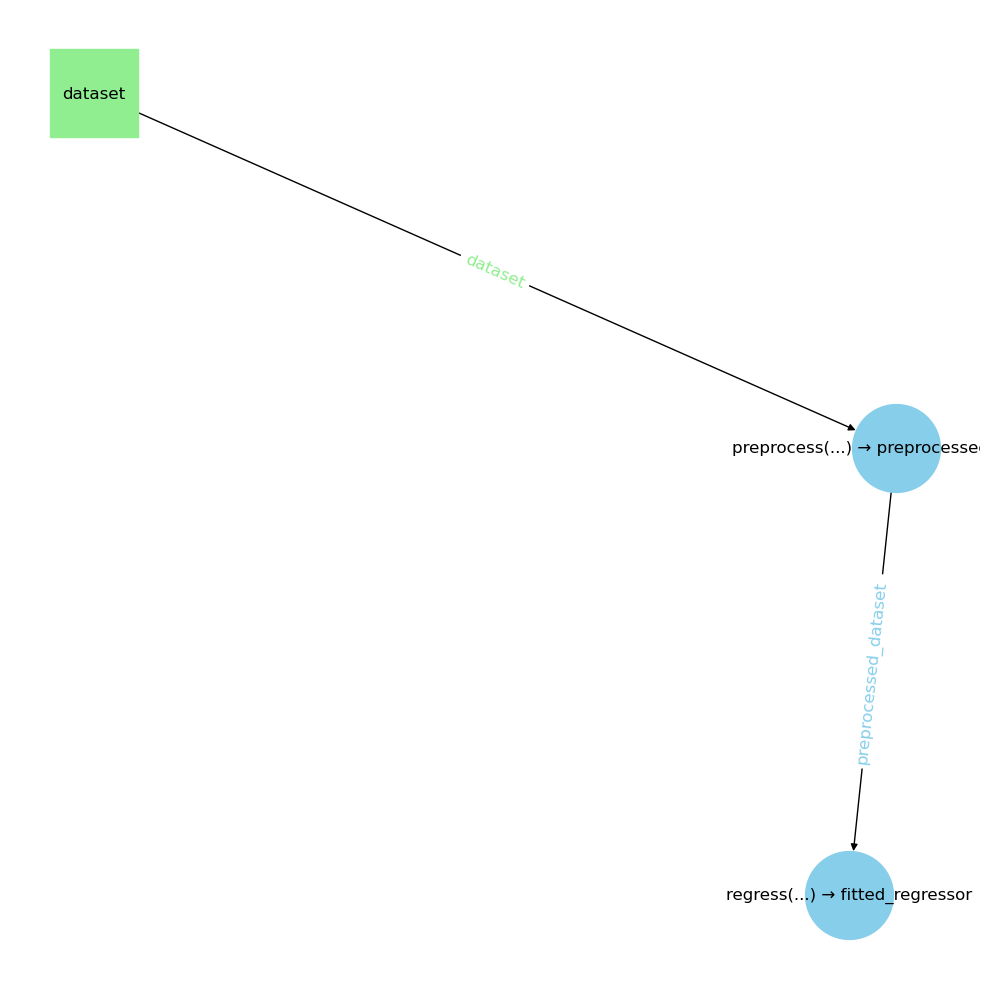

In [9]:
print("Graph nodes:", pipeline_train.graph.nodes)
pipeline_train.visualize()